In [ ]:
import os, sys
# To suppress the prints from Iterative Phase Estimation function
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [ ]:
import matplotlib.pyplot as plt
def draw_plot(axs, idx, title:str, x:list[float], x_label:str, y:list[float], y_label:str):
    "Draw the subplot of title with the x-axis and the y-axis labeled as x-label and y-axis relatively."
    axs[idx[0], idx[1]].plot(x, y)
    axs[idx[0], idx[1]].set_xlabel(x_label)
    axs[idx[0], idx[1]].set_ylabel(y_label)
    axs[idx[0], idx[1]].set_title(title)

Data loaded from ../data\hubbard/h_2.pkl
[[2. 1.]
 [1. 2.]]


C:\Users\jhlee\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


one plot generated
one plot generated
one plot generated
one plot generated


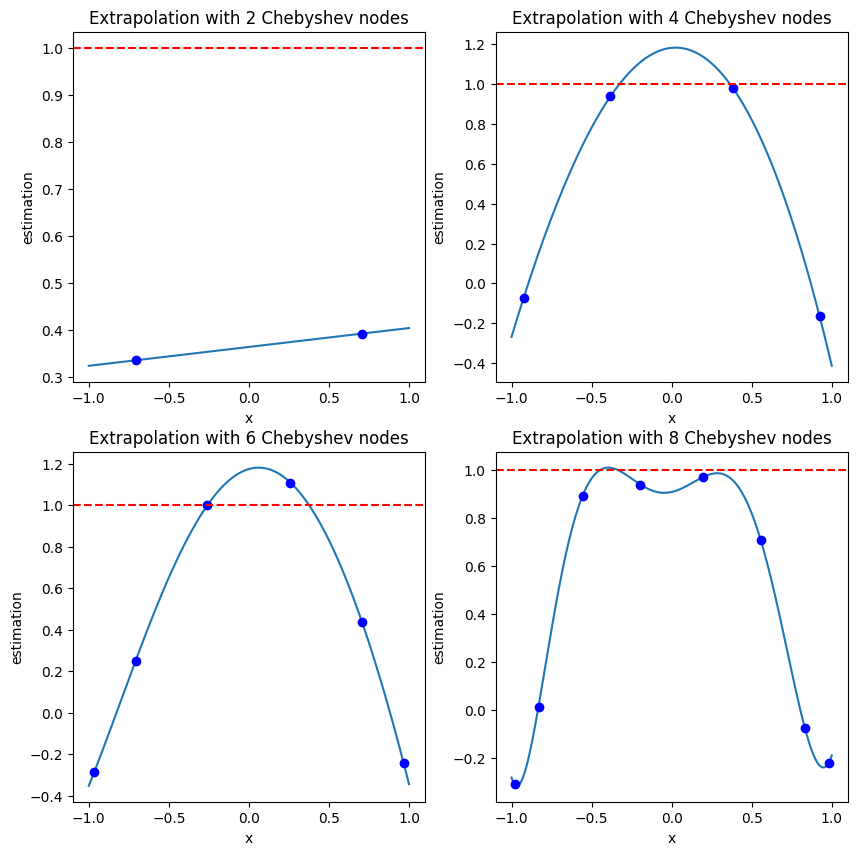

In [5]:
from contextlib import redirect_stdout
from qiskit_aer import Aer
from scripts.algo.iterative_phase_estimation import iterative_phase_estimation_v2
from scripts.algo.chebyshev import chebyshev_nodes, chebyshev_barycentric_interp_point
import scipy
import numpy as np
from qiskit_algorithms import NumPyEigensolver
from scripts.algo.qdrift import QDrift
from scripts.database import DataManager, Hubbard

fig, axs = plt.subplots(2, 2) # Figure
fig.set_figheight(10)
fig.set_figwidth(10)
data = DataManager("../data")  # Create DataManager instance
eigensolver = NumPyEigensolver() # Create Eigensolver
domain = np.linspace(-1, 1, 200) # Domain for extrapolation
selected_backend = Aer.get_backend('qasm_simulator') # Simulation backend from qiskit

ld = data.load('hubbard', "h_2") # load the hubbard model
ld.decompose(-1, 2) # t = +1 and u = +2
decomposition = ld.get_decomp()
obt = decomposition.get_term('obt')
tbt = decomposition.get_term('tbt')
hubbard_matrix = obt.matrix + tbt.matrix
print(hubbard_matrix)
exact_eigenvalue, eigenvectors = scipy.linalg.eig(hubbard_matrix)
expected = min(exact_eigenvalue) # Get the minimum eigenvalue of the hamiltonian

t = 100 # time = 1
num_eval = 1000 # number of iterations of phase estimation
lm = ld.get_decomp().sum_abs_coeff
axs_x = 0
axs_y = 0

oracle = QDrift(ld, t)

for n in range(2, 10, 2):  # number of the Chebyshev nodes
    data_point = [] # Storage for data points to be interpolated
    nodes = chebyshev_nodes(n) # The n Chebyshev nodes
    for node in nodes:
        estimations = [] # Storage for each eigenvalue estimation of individual unitary 
        # total = 0
        N = np.ceil(t / np.abs(node)) # number of samplings
        h_list, v_list = oracle.qdrift(N)
        for i in range(len(h_list)):
            exact_eigenvalue, eigenvectors = scipy.linalg.eig(h_list[i]) # Get eigenvectors and values for each unitary
            eigenstate = eigenvectors[:, np.argmin(exact_eigenvalue)] # pick eigenstate that corresponds to smallest eigenvalue
            #U = scipy.linalg.expm(-1j * h * t) # Evolution for phase estimation
            with HiddenPrints(): # Do Iterative Phase Estimation
                p_0, qc = iterative_phase_estimation_v2(v_list[i], num_eval, eigenstate, selected_backend, num_qubits=1)
            estimated_eigenvalue = 2 * np.arccos(np.sqrt(p_0)) # Estimate eigenvalue
            if min(exact_eigenvalue) < 0:
                estimated_eigenvalue *= -1
            estimations.append(N * estimated_eigenvalue / lm / t)
            # total += estimated_eigenvalue
        # print(f"total: {total * N / 2 / t / len(h_list)}")
        data_point.append(np.average(estimations)) # Average out the estimations
    # plot
    draw_plot(axs, (axs_x, axs_y), f'Extrapolation with {len(nodes)} Chebyshev nodes', domain, 'x', [chebyshev_barycentric_interp_point(x, n, data_point) for x in domain], 'estimation')
    axs[axs_x, axs_y].plot(nodes, data_point, 'bo')
    axs[axs_x, axs_y].axhline(expected, color='r', linestyle='--')
    axs_x = (axs_x + axs_y) % 2
    axs_y = (axs_y + 1) % 2
    
    print("one plot generated")